In [1]:
%load_ext autoreload
%autoreload 2

from __future__ import annotations

import os
import functools as ft

import catboost as cb
import numpy as np
import pandas as pd
import polars as pl
from catboost.utils import get_gpu_device_count

# from mts_ml_cup.validation import split_folds, print_metrics
from mts_ml_cup.urls import clean_url

cb_device = "GPU" if get_gpu_device_count() > 0 else "CPU"
cb_device

'GPU'

In [3]:
df = pl.read_parquet("../data/processed/sessions.pq")

In [4]:
(df["user_id"] == 1435).any()

True

In [4]:
rosstat = pl.read_csv("../data/processed/rosstat-mts.csv")

In [9]:
sex = (
    rosstat
    .groupby("region_mts")
    .agg(
        [
            (pl.col("men").sum() / (pl.col("men") + pl.col("women")).sum()).alias("men_share"),
            (pl.col("women").sum() / (pl.col("men") + pl.col("women")).sum()).alias("women_share"),
        ]
    )
    .filter(pl.col("region_mts").is_not_null())
)
sex

region_mts,men_share,women_share
str,f64,f64
"""Иркутская обла...",0.463512,0.536488
"""Республика Мар...",0.466867,0.533133
"""Магаданская об...",0.483606,0.516394
"""Самарская обла...",0.458591,0.541409
"""Республика Алт...",0.475571,0.524429
"""Краснодарский ...",0.463374,0.536626
"""Ульяновская об...",0.460388,0.539612
"""Ростовская обл...",0.465764,0.534236
"""Рязанская обла...",0.458599,0.541401


In [23]:
sex_by_age = (
    rosstat
    .with_columns(pl.col("age_bucket").clip_min(1))
    .groupby(["region_mts", "age_bucket"])
    .agg(
        [
            (pl.col("men").sum() / (pl.col("men") + pl.col("women")).sum()).alias("men_share"),
            (pl.col("women").sum() / (pl.col("men") + pl.col("women")).sum()).alias("women_share"),
        ]
    )
    .filter(pl.col("region_mts").is_not_null())
    .pivot(
        values=["men_share", "women_share"],
        index="region_mts",
        columns="age_bucket",
    )
)
sex_by_age

region_mts,men_share_5,men_share_1,men_share_4,men_share_3,men_share_2,men_share_6,women_share_5,women_share_1,women_share_4,women_share_3,women_share_2,women_share_6
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Республика Кал...",0.456852,0.511166,0.4814,0.504379,0.519552,0.352738,0.543148,0.488834,0.5186,0.495621,0.480448,0.647262
"""Курганская обл...",0.434451,0.510849,0.46528,0.493598,0.533292,0.325624,0.565549,0.489151,0.53472,0.506402,0.466708,0.674376
"""Пензенская обл...",0.43279,0.514182,0.471619,0.497859,0.508045,0.319558,0.56721,0.485818,0.528381,0.502141,0.491955,0.680442
"""Ненецкий АО""",0.4344,0.520934,0.492152,0.519729,0.529391,0.344997,0.5656,0.479066,0.507848,0.480271,0.470609,0.655003
"""Санкт-Петербур...",0.411747,0.506639,0.468068,0.484234,0.494758,0.320739,0.588253,0.493361,0.531932,0.515766,0.505242,0.679261
"""Московская обл...",0.423405,0.517649,0.473522,0.483444,0.501523,0.322166,0.576595,0.482351,0.526478,0.516556,0.498477,0.677834
"""Орловская обла...",0.426197,0.5071,0.462346,0.489141,0.505605,0.309958,0.573803,0.4929,0.537654,0.510859,0.494395,0.690042
"""Мурманская обл...",0.424961,0.535998,0.483457,0.510224,0.556661,0.289154,0.575039,0.464002,0.516543,0.489776,0.443339,0.710846
"""Республика Мор...",0.445535,0.510605,0.488411,0.523012,0.538174,0.320923,0.554465,0.489395,0.511589,0.476988,0.461826,0.679077


In [32]:
age = (
    rosstat
    .with_columns(pl.col("age_bucket").clip_min(1))
    .groupby(["region_mts", "age_bucket"])
    .agg(
        [
            (pl.col("men") + pl.col("women")).sum().alias("people")
        ]
    )
    .filter(pl.col("region_mts").is_not_null())
    .pivot(
        values="people",
        index="region_mts",
        columns="age_bucket",
    )
    .rename({str(i): f"age_bucket_{i}" for i in range(1, 7)})
    .with_columns(
        (
            pl.col("age_bucket_1") 
            + pl.col("age_bucket_2") 
            + pl.col("age_bucket_3")
            + pl.col("age_bucket_4")
            + pl.col("age_bucket_5")
            + pl.col("age_bucket_6")
        ).alias("total")
    )
    .with_columns(
        [
            (pl.col(f"age_bucket_{i}") / pl.col("total")).alias(f"age_bucket_{i}_share")
            for i in range(1, 7)
        ]
    )
    .select(["region_mts"] + [f"age_bucket_{i}_share" for i in range(1, 7)])
)
age

region_mts,age_bucket_1_share,age_bucket_2_share,age_bucket_3_share,age_bucket_4_share,age_bucket_5_share,age_bucket_6_share
str,f64,f64,f64,f64,f64,f64
"""Республика Ком...",0.299745,0.127755,0.168416,0.138464,0.142601,0.123019
"""Псковская обла...",0.266783,0.13274,0.144459,0.129745,0.150156,0.176116
"""Республика Инг...",0.418711,0.17105,0.136149,0.108559,0.096211,0.069321
"""Саратовская об...",0.262362,0.142728,0.151845,0.134184,0.142407,0.166475
"""Ханты-Мансийск...",0.334441,0.147413,0.177543,0.137318,0.129751,0.073535
"""Алтайский край...",0.287168,0.130759,0.154706,0.125883,0.145215,0.156268
"""Костромская об...",0.27845,0.125287,0.151433,0.129899,0.153258,0.161673
"""Рязанская обла...",0.250959,0.137528,0.147426,0.134413,0.147008,0.182666
"""Вологодская об...",0.287385,0.131352,0.159622,0.12431,0.145954,0.151378


In [33]:
region_stats = sex.join(age, how="inner", on="region_mts").join(sex_by_age, how="inner", on="region_mts")

In [19]:
top_regions = pl.read_parquet("../data/features/geo/top_region.pq")

In [35]:
region_rosstat = (
    top_regions
    .join(region_stats, how="inner", left_on="top_region", right_on="region_mts")
    .select(pl.exclude("top_region"))
)

In [37]:
region_rosstat.write_parquet("../data/features/geo/rosstat.pq")

# Подготовка урлов и эмбеддингов

In [16]:
%%time
urls = (
    df
    .join(
        other=df["url_host"]
        .unique()
        .to_frame()
        .with_columns(pl.col("url_host").apply(clean_url).alias("url_cleaned")),
        how="left",
        on="url_host",
    )
    .groupby(["user_id", "url_cleaned"])
    .agg(pl.col("request_cnt").sum())
    .sort(["user_id", "request_cnt", "url_cleaned"], reverse=[False, True, False])
    .groupby("user_id").agg(pl.col("url_cleaned"))
    .with_columns(
        pl.col("url_cleaned").apply(lambda urls: " ".join(urls)).alias("urls_text"),
    )
    .select(["user_id", "urls_text"])
)

CPU times: user 4min, sys: 39.9 s, total: 4min 40s
Wall time: 1min 53s


In [17]:
urls.write_parquet("../data/features/url/urls_text-cleaned.pq")

In [19]:
! ls -lh ../data/features/embs

total 1.9G
-rw-rw-r-- 1 ababkin ababkin 418M Mar  2 07:10 vectors.pq
-rw-rw-r-- 1 ababkin ababkin 1.5G Mar  3 16:41 vectors-v2-hist.pq


In [1]:
import torch
import joblib as jbl

/home/ababkin/.cache/pypoetry/virtualenvs/mts-ml-cup-qFoUb2su-py3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
embs = torch.load("../data/ptls/embeddings-v3.pt")

In [5]:
emb = pd.DataFrame(embs.numpy(), columns=[f"emb_{i}" for i in range(1, embs.shape[1] + 1)])
emb_ = pd.DataFrame()
emb_["ptls_embeddings"] = emb.values.tolist()

In [6]:
emb_["user_id"] = jbl.load("../data/ptls/user_ids-v3.jbl")

In [7]:
emb_ = pl.from_pandas(emb_)

In [8]:
emb_ = emb_.with_columns(pl.col("ptls_embeddings").cast(pl.List(pl.Float32)))

In [9]:
emb_ = emb_.with_columns(pl.col("user_id").cast(pl.UInt32))

In [10]:
emb_.write_parquet("../data/features/embs/vectors-v3.pq")

# Джойн фичей

In [2]:
def join_precomputed_features(dataset: pl.DataFrame, black_list: set[str] = None) -> pl.DataFrame:
    black_list = black_list or set()
    for feat_type in os.listdir("../data/features"):
        for features_file in os.listdir(f"../data/features/{feat_type}"):
            if not features_file.endswith(".pq") or features_file in black_list:
                continue
            
            features = (
                pl.read_parquet(f"../data/features/{feat_type}/{features_file}")
                .with_columns(pl.col("user_id").cast(pl.UInt32))
            )
            dataset = dataset.join(features, how="left", on="user_id")
    return dataset

In [3]:
%%time
black_list = {
    "urls_text-cleaned.pq", 
    "vectors.pq", 
    "vectors-v2-hist.pq", 
    "vectors-v2.pq",
    "vectors-v3.pq",
}

train = join_precomputed_features(
    pl.read_parquet("../data/processed/targets.pq"),
    black_list=black_list,
)
test = join_precomputed_features(
    pl.read_parquet("../data/processed/test.pq"),
    black_list=black_list,
)

CPU times: user 7.53 s, sys: 2.72 s, total: 10.2 s
Wall time: 4.93 s


In [4]:
test_urls = test["urls_text"].apply(lambda x: x.split()).explode().unique()

In [5]:
%%time
train_urls = train["urls_text"].apply(lambda x: x.split()).explode().unique()

CPU times: user 7.99 s, sys: 1.41 s, total: 9.4 s
Wall time: 9.4 s


In [6]:
only_train_urls = set(train_urls) - set(test_urls)

In [7]:
def filter_urls(urls_str: str, black_list: set[str] = only_train_urls) -> str:
    urls = urls_str.split()
    urls_white_list = [url for url in urls if url not in black_list]
    return " ".join(urls_white_list)

In [8]:
%%time
train_urls_ = (
    train
    .with_columns(pl.col("urls_text").apply(filter_urls).alias("urls_text_filtered"))
    .select(["user_id", "urls_text", "urls_text_filtered"])
)

CPU times: user 5.32 s, sys: 878 ms, total: 6.2 s
Wall time: 6.2 s


In [9]:
train_urls_

user_id,urls_text,urls_text_filtered
u32,str,str
350459,"""i.ytimg.com ya...","""i.ytimg.com ya..."
188276,"""news-af.feedne...","""news-af.feedne..."
99002,"""vk.com ad.mail...","""vk.com ad.mail..."
155506,"""instagram.com ...","""instagram.com ..."
213873,"""s0.2mdn.net st...","""s0.2mdn.net st..."
212300,"""yandex.ru avat...","""yandex.ru avat..."
268755,"""yandex.ru yast...","""yandex.ru yast..."
350740,"""apple.com goog...","""apple.com goog..."
357123,"""googleads.g.do...","""googleads.g.do..."


In [10]:
%%time
test_urls_ = (
    test
    .with_columns(pl.col("urls_text").apply(filter_urls).alias("urls_text_filtered"))
    .select(["user_id", "urls_text", "urls_text_filtered"])
)

CPU times: user 2.78 s, sys: 115 ms, total: 2.9 s
Wall time: 2.9 s


In [11]:
test_urls_

user_id,urls_text,urls_text_filtered
u32,str,str
221301,"""apple.com inst...","""apple.com inst..."
31271,"""avatars.mds.ya...","""avatars.mds.ya..."
211594,"""unblock.mts.ru...","""unblock.mts.ru..."
253119,"""ad.mail.ru ava...","""ad.mail.ru ava..."
192578,"""apple.com iclo...","""apple.com iclo..."
268458,"""yandex.ru i.yt...","""yandex.ru i.yt..."
205507,"""i.ytimg.com""","""i.ytimg.com"""
341343,"""yandex.ru mail...","""yandex.ru mail..."
282144,"""apple.com inst...","""apple.com inst..."


In [12]:
(test_urls_["urls_text"] == test_urls_["urls_text_filtered"]).all()

True

In [13]:
(train_urls_["urls_text"] == train_urls_["urls_text_filtered"]).mean()

0.8004148148148148

In [14]:
urls_filtered = (
    pl.concat(
        [
            train_urls_.select(["user_id", "urls_text_filtered"]), 
            test_urls_.select(["user_id", "urls_text_filtered"]),
        ]
    )
)

In [16]:
urls_filtered.write_parquet("../data/features/url/urls_text-filtered.pq")

In [64]:
u = pl.read_parquet("../data/features/url/urls_text.pq")

In [84]:
(pl.read_parquet("../data/raw/public_train.pqt")["user_id"] == 1435).any()

False

In [85]:
(pl.read_parquet("../data/raw/submit_2.pqt")["user_id"] == 1435).any()

False

In [ ]:
(pl.read_parquet("../data/raw/public_train.pqt")["user_id"] == 1435).any()

In [86]:
unk_users = set(u["user_id"]) - set(urls_filtered["user_id"])

In [88]:
len(unk_users)

593

In [21]:
test.select(pl.exclude(None))

ValueError: A NoneType object is not a correct polars DataType.Hint: use the class without instantiating it.

# Эмбеддинги как эмбеддинги для катбуста

In [4]:
def filter_sex(fold: pl.DataFrame) -> pl.DataFrame:
    return (
        fold
        .filter(pl.col("is_male").is_not_null())
        .select(pl.exclude(["user_id", "age", "age_bucket"]))
    )


def filter_age(fold: pl.DataFrame) -> pl.DataFrame:
    return (
        fold
        .filter(pl.col("age_bucket").is_not_null())
        .with_columns(pl.col("age_bucket").clip_min(1))
        .select(pl.exclude(["user_id", "is_male", "age"]))
    )


def pool(fold: pl.DataFrame, target_col: str) -> cb.Pool:
    return cb.Pool(
        data=fold.select(pl.exclude(target_col)).to_pandas(),
        label=fold[target_col].to_pandas(),
        cat_features=[
            "top_part_of_day",
            "top_city",
            "top_region",
            "device_manufacturer",
            "device_model",
        ],
        text_features=["urls_text"],
        # embedding_features=["ptls_embeddings"],
    )


def pool_sex(fold: pl.DataFrame) -> cb.Pool:
    return pool(filter_sex(fold), target_col="is_male")


def pool_age(fold: pl.DataFrame) -> cb.Pool:
    return pool(filter_age(fold), target_col="age_bucket")

In [6]:
sex_models = []
age_models = []
for i, (train_idx, val_idx) in enumerate(split_folds(train)):
    train_fold = train[train_idx]
    val_fold = train[val_idx]
    
    train_fold_sex, val_fold_sex = pool_sex(train_fold), pool_sex(val_fold)
    train_fold_age, val_fold_age = pool_age(train_fold), pool_age(val_fold)
    
    model_fold_sex = cb.CatBoostClassifier(
        eval_metric="Logloss",
        loss_function="Logloss",
        iterations=100_000,
        early_stopping_rounds=1_000,
        random_seed=777,
        allow_writing_files=False,
        task_type=cb_device,
    )
    model_fold_sex.fit(train_fold_sex, eval_set=val_fold_sex, verbose=1_000)
    
    
    model_fold_age = cb.CatBoostClassifier(
        eval_metric="MultiClass",
        loss_function="MultiClass",
        iterations=100_000,
        early_stopping_rounds=1_000,
        random_seed=777,
        allow_writing_files=False,
        task_type=cb_device,
    )
    model_fold_age.fit(train_fold_age, eval_set=val_fold_age, verbose=1_000)
    
    print()
    print(f"{'-' * 20} fold = {i} {'-' * 20}")
    print_metrics(
        is_male=val_fold_sex.get_label(),
        is_male_probs=model_fold_sex.predict_proba(val_fold_sex)[:, 1],
        age_bucket=val_fold_age.get_label(),
        age_bucket_probs=model_fold_age.predict(val_fold_age),
    )
    print(f"{'-' * 20} fold = {i} {'-' * 20}")
    print()
    
    sex_models.append(model_fold_sex)
    age_models.append(model_fold_age)

Learning rate set to 0.006712
0:	learn: 0.6899487	test: 0.6899166	best: 0.6899166 (0)	total: 15.2ms	remaining: 25m 21s
1000:	learn: 0.4538109	test: 0.4555956	best: 0.4555956 (1000)	total: 15.2s	remaining: 25m 2s
2000:	learn: 0.4452855	test: 0.4493222	best: 0.4493222 (2000)	total: 29.7s	remaining: 24m 14s
3000:	learn: 0.4394702	test: 0.4458091	best: 0.4458091 (3000)	total: 43.4s	remaining: 23m 22s
4000:	learn: 0.4351243	test: 0.4436573	best: 0.4436573 (4000)	total: 57s	remaining: 22m 46s
5000:	learn: 0.4315438	test: 0.4422172	best: 0.4422169 (4999)	total: 1m 10s	remaining: 22m 21s
6000:	learn: 0.4283356	test: 0.4411002	best: 0.4411002 (6000)	total: 1m 24s	remaining: 21m 59s
7000:	learn: 0.4254154	test: 0.4402080	best: 0.4402080 (7000)	total: 1m 37s	remaining: 21m 40s
8000:	learn: 0.4227274	test: 0.4394511	best: 0.4394504 (7995)	total: 1m 51s	remaining: 21m 21s
9000:	learn: 0.4201510	test: 0.4388080	best: 0.4388080 (9000)	total: 2m 5s	remaining: 21m 7s
10000:	learn: 0.4176818	test: 0.438

In [15]:
sex_models = []
age_models = []
for i, (train_idx, val_idx) in enumerate(split_folds(train)):
    train_fold = train[train_idx]
    val_fold = train[val_idx]
    
    train_fold_sex, val_fold_sex = pool_sex(train_fold), pool_sex(val_fold)
    train_fold_age, val_fold_age = pool_age(train_fold), pool_age(val_fold)
    
    model_fold_sex = cb.CatBoostClassifier(
        eval_metric="Logloss",
        loss_function="Logloss",
        iterations=100_000,
        early_stopping_rounds=1_000,
        random_seed=777,
        max_bin=254,
        allow_writing_files=False,
        task_type=cb_device,
    )
    model_fold_sex.fit(train_fold_sex, eval_set=val_fold_sex, verbose=1_000)
    
    
    model_fold_age = cb.CatBoostClassifier(
        eval_metric="MultiClass",
        loss_function="MultiClass",
        iterations=100_000,
        early_stopping_rounds=1_000,
        random_seed=777,
        max_bin=254,
        allow_writing_files=False,
        task_type=cb_device,
    )
    model_fold_age.fit(train_fold_age, eval_set=val_fold_age, verbose=1_000)
    
    print()
    print(f"{'-' * 20} fold = {i} {'-' * 20}")
    print_metrics(
        is_male=val_fold_sex.get_label(),
        is_male_probs=model_fold_sex.predict_proba(val_fold_sex)[:, 1],
        age_bucket=val_fold_age.get_label(),
        age_bucket_probs=model_fold_age.predict(val_fold_age),
    )
    print(f"{'-' * 20} fold = {i} {'-' * 20}")
    print()
    
    sex_models.append(model_fold_sex)
    age_models.append(model_fold_age)

Learning rate set to 0.006712
0:	learn: 0.6899226	test: 0.6898879	best: 0.6898879 (0)	total: 16.4ms	remaining: 27m 15s
1000:	learn: 0.4537439	test: 0.4555650	best: 0.4555650 (1000)	total: 15.5s	remaining: 25m 29s
2000:	learn: 0.4452150	test: 0.4493243	best: 0.4493243 (2000)	total: 30.3s	remaining: 24m 44s
3000:	learn: 0.4393644	test: 0.4458045	best: 0.4458045 (3000)	total: 44.4s	remaining: 23m 53s
4000:	learn: 0.4349957	test: 0.4436605	best: 0.4436605 (4000)	total: 58.5s	remaining: 23m 22s
5000:	learn: 0.4313805	test: 0.4421885	best: 0.4421883 (4999)	total: 1m 12s	remaining: 22m 54s
6000:	learn: 0.4281897	test: 0.4410971	best: 0.4410971 (6000)	total: 1m 26s	remaining: 22m 32s
7000:	learn: 0.4252527	test: 0.4402117	best: 0.4402117 (7000)	total: 1m 40s	remaining: 22m 14s
8000:	learn: 0.4225680	test: 0.4394926	best: 0.4394926 (7999)	total: 1m 54s	remaining: 21m 56s
9000:	learn: 0.4200051	test: 0.4388715	best: 0.4388715 (9000)	total: 2m 8s	remaining: 21m 39s
10000:	learn: 0.4175242	test: 0

In [20]:
test_pool.slice([1, 2, 3]).get_label()

In [7]:
test_pool = cb.Pool(
    data=test.select(pl.exclude("user_id")).to_pandas(),
    cat_features=[
        "top_part_of_day",
        "top_city",
        "top_region",
        "device_manufacturer",
        "device_model",
    ],
    text_features=["urls_text"],
    # embedding_features=["ptls_embeddings"],
)

In [8]:
test_is_male = 0
for model in sex_models:
    test_is_male += model.predict_proba(test_pool)[:, 1] / len(sex_models)

<Axes: ylabel='Frequency'>

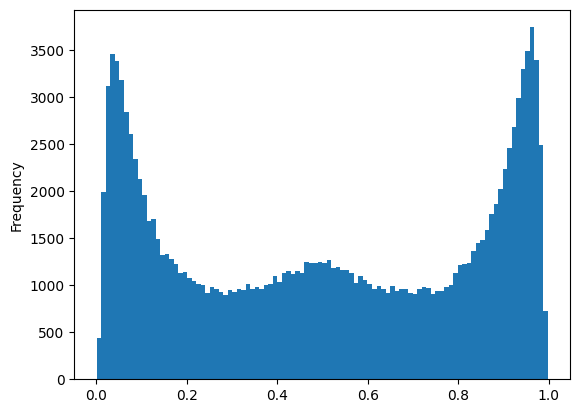

In [9]:
pd.Series(test_is_male).plot.hist(bins=100)

In [10]:
%%time
test_age_probas = 0
for model in age_models:
    test_age_probas += model.predict_proba(test_pool) / len(age_models)
test_age_buckets = np.argmax(test_age_probas, axis=1) + 1

CPU times: user 3min 20s, sys: 0 ns, total: 3min 20s
Wall time: 25.9 s


In [11]:
submission = pd.DataFrame()
submission["user_id"] = test["user_id"].to_pandas()
submission["is_male"] = test_is_male
submission["age"] = test_age_buckets

In [12]:
submission.to_csv("../submissions/no-emb-raw.csv", index=False)

In [13]:
submission

,user_id,is_male,age
0,221301,0.849452,1
1,31271,0.513460,3
2,211594,0.598519,2
3,253119,0.618145,2
4,192578,0.879253,2
...,...,...,...
144719,415284,0.501282,2
144720,415285,0.573555,3
144721,415286,0.496546,3
144722,415306,0.779264,2


<Axes: title={'center': 'sex'}>

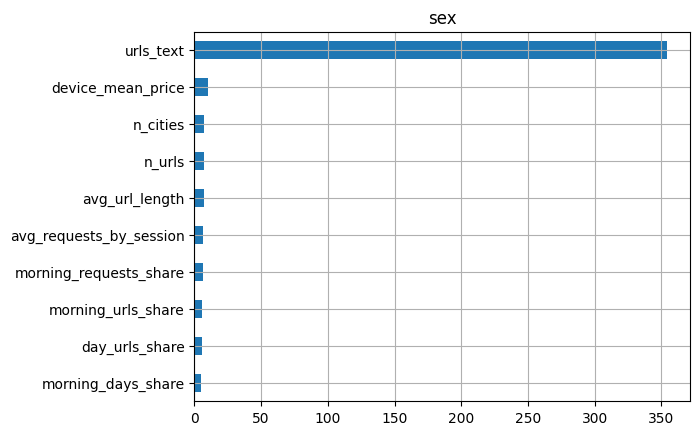

In [14]:
(
    pd.Series(
        sum(m.feature_importances_ for m in sex_models), index=sex_models[0].feature_names_
    ).sort_values(ascending=True).tail(10).plot.barh(
        grid=True,
        title="sex"
    )
)

<Axes: title={'center': 'age'}>

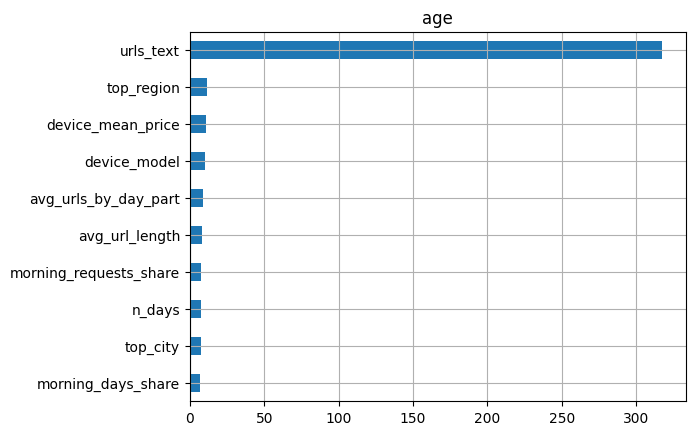

In [15]:
(
    pd.Series(
        sum(m.feature_importances_ for m in age_models), index=age_models[0].feature_names_
    ).sort_values(ascending=True).tail(10).plot.barh(
        grid=True,
        title="age"
    )
)

# url as text

In [6]:
%%time
train_urls_as_text = (
    join_precomputed_features(train)
    .join(urls.select(["user_id", "urls_text"]), how="inner", on="user_id")
    
)
test_urls_as_text = (
    join_precomputed_features(test)
    .join(urls.select(["user_id", "urls_text"]), how="inner", on="user_id")
)

CPU times: user 9.79 s, sys: 6.2 s, total: 16 s
Wall time: 2.83 s


In [7]:
%%time
train_sex_text = (
    train_urls_as_text
    .filter(pl.col("is_male").is_not_null())
    .select(pl.exclude(["user_id", "age", "age_bucket"]))
)
train_age_text = (
    train_urls_as_text
    .filter(pl.col("age_bucket") > 0)
    .select(pl.exclude(["user_id", "age", "is_male"]))
)

CPU times: user 1.07 s, sys: 3.27 s, total: 4.35 s
Wall time: 1.18 s


In [8]:
train_sex_text_pool = cb.Pool(
    data=train_sex_text.select(pl.exclude("is_male")).to_pandas(),
    label=train_sex_text["is_male"].to_pandas(),
    cat_features=[
        "top_part_of_day",
        "top_city",
        "top_region",
        "device_manufacturer",
        "device_model",
    ],
    text_features=["urls_text"],
)
train_age_text_pool = cb.Pool(
    data=train_age_text.select(pl.exclude("age_bucket")).to_pandas(),
    label=train_age_text["age_bucket"].to_pandas(),
    cat_features=[
        "top_part_of_day",
        "top_city",
        "top_region",
        "device_manufacturer",
        "device_model",
    ],
    text_features=["urls_text"],
)

In [9]:
%%time
_, cv_models_sex_text = cb.cv(
    pool=train_sex_text_pool,
    params={
        "eval_metric": "Logloss",
        "loss_function": "Logloss",
        "iterations": 10_000,
        "early_stopping_rounds": 20,
        "random_seed": 777,
        "allow_writing_files": False,
    },
    folds=KFold(5, shuffle=True, random_state=777),
    verbose=100,
    return_models=True,
)

Training on fold [0/5]
0:	learn: 0.6929682	test: 0.6929323	best: 0.6929323 (0)	total: 138ms	remaining: 22m 58s
100:	learn: 0.5770304	test: 0.5779740	best: 0.5779740 (100)	total: 9.39s	remaining: 15m 20s
200:	learn: 0.5479977	test: 0.5500185	best: 0.5500185 (200)	total: 18.5s	remaining: 14m 59s
300:	learn: 0.5305322	test: 0.5337562	best: 0.5337562 (300)	total: 27.3s	remaining: 14m 40s
400:	learn: 0.5189949	test: 0.5231744	best: 0.5231744 (400)	total: 36.4s	remaining: 14m 30s
500:	learn: 0.5095985	test: 0.5151352	best: 0.5151352 (500)	total: 46s	remaining: 14m 32s
600:	learn: 0.5022368	test: 0.5089833	best: 0.5089833 (600)	total: 55.9s	remaining: 14m 33s
700:	learn: 0.4963636	test: 0.5043682	best: 0.5043682 (700)	total: 1m 4s	remaining: 14m 16s
800:	learn: 0.4911794	test: 0.5003375	best: 0.5003375 (800)	total: 1m 14s	remaining: 14m 11s
900:	learn: 0.4867332	test: 0.4970246	best: 0.4970246 (900)	total: 1m 22s	remaining: 13m 53s
1000:	learn: 0.4827016	test: 0.4940905	best: 0.4940905 (1000)

CatBoostError: catboost/libs/model/model.cpp:1837: Models summation is not supported for models with text features

In [10]:
%%time
_, cv_models_age_text = cb.cv(
    pool=train_age_text_pool,
    params={
        "eval_metric": "MultiClass",
        "loss_function": "MultiClass",
        "iterations": 10_000,
        "early_stopping_rounds": 20,
        "random_seed": 777,
        "allow_writing_files": False,
    },
    folds=KFold(5, shuffle=True, random_state=777),
    verbose=100,
    return_models=True,
)

Training on fold [0/5]
0:	learn: 1.7751695	test: 1.7752288	best: 1.7752288 (0)	total: 422ms	remaining: 1h 10m 20s
100:	learn: 1.3858756	test: 1.3910840	best: 1.3910840 (100)	total: 47s	remaining: 1h 16m 46s
200:	learn: 1.3434891	test: 1.3511746	best: 1.3511746 (200)	total: 1m 30s	remaining: 1h 13m 25s
300:	learn: 1.3227559	test: 1.3327021	best: 1.3327021 (300)	total: 2m 11s	remaining: 1h 10m 49s
400:	learn: 1.3072832	test: 1.3190720	best: 1.3190720 (400)	total: 2m 53s	remaining: 1h 9m 17s
500:	learn: 1.2941968	test: 1.3082818	best: 1.3082818 (500)	total: 3m 35s	remaining: 1h 7m 59s
600:	learn: 1.2843813	test: 1.3006943	best: 1.3006943 (600)	total: 4m 16s	remaining: 1h 6m 50s
700:	learn: 1.2763102	test: 1.2947668	best: 1.2947668 (700)	total: 4m 57s	remaining: 1h 5m 49s
800:	learn: 1.2695754	test: 1.2899941	best: 1.2899941 (800)	total: 5m 38s	remaining: 1h 4m 43s
900:	learn: 1.2633377	test: 1.2857955	best: 1.2857955 (900)	total: 6m 19s	remaining: 1h 3m 51s
1000:	learn: 1.2577522	test: 1.

In [33]:
test_text_pool = cb.Pool(
    data=test_urls_as_text.select(pl.exclude("user_id")).to_pandas(),
    cat_features=[
        "top_part_of_day",
        "top_city",
        "top_region",
        "device_manufacturer",
        "device_model",
    ],
    text_features=["urls_text"],
)

In [34]:
test_pred_sex_text = 0
for model in cv_models_sex_text:
    test_pred_sex_text += model.predict(test_text_pool, prediction_type="Probability")[:, 1]
test_pred_sex_text /= len(cv_models_sex_text)

In [51]:
test_pred_age_text = 0
for model in cv_models_age_text:
    test_pred_age_text += model.predict(test_text_pool, prediction_type="Probability")
test_pred_age_text /= len(cv_models_age_text)
test_pred_age_text = np.argmax(test_pred_age_text, axis=1) + 1

In [52]:
submission_text = pd.DataFrame()
submission_text["user_id"] = test_urls_as_text["user_id"].to_pandas()
submission_text["age"] = test_pred_age_text
submission_text["is_male"] = test_pred_sex_text

In [54]:
submission_text.to_csv("../submissions/cb-text.csv", index=False)

# url as text with different validation

In [5]:
def decode_url(url: str) -> str:
    try:
        return bytearray(url, "utf-8").decode("idna")
    except Exception:
        return url

In [6]:
%%time
urls_ = (
    df
    .with_columns(pl.col("url_host").apply(decode_url))
    .groupby(["user_id", "url_host"])
    .agg(pl.col("request_cnt").sum())
    .sort(["user_id", "request_cnt", "url_host"], reverse=[False, True, False])
    .groupby("user_id").agg(pl.col("url_host"))
    .with_columns(pl.col("url_host").apply(lambda urls: " ".join(urls)).alias("urls_text"))
)

CPU times: user 13min 48s, sys: 5min 28s, total: 19min 17s
Wall time: 12min 43s


In [19]:
%%time
df_ = df.with_columns(pl.col("url_host").apply(decode_url).alias("url_decoded"))

CPU times: user 8min 15s, sys: 2min, total: 10min 16s
Wall time: 10min 19s


In [22]:
users_by_url = df_.groupby("url_decoded").agg(pl.col("user_id").n_unique())

In [27]:
users_by_url.sort("user_id", reverse=True).with_columns(pl.col("user_id") / df["user_id"].n_unique())

url_decoded,user_id
str,f64
"""googleads.g.do...",0.950026
"""yandex.ru""",0.930386
"""avatars.mds.ya...",0.921446
"""i.ytimg.com""",0.918017
"""yastatic.net""",0.915539
"""ad.mail.ru""",0.902294
"""vk.com""",0.900753
"""tpc.googlesynd...",0.843081
"""ads.adfox.ru""",0.798436


In [7]:
%%time
train_urls_as_text_ = (
    join_precomputed_features(train)
    .join(urls_.select(["user_id", "urls_text"]), how="inner", on="user_id")
    
)
test_urls_as_text_ = (
    join_precomputed_features(test)
    .join(urls_.select(["user_id", "urls_text"]), how="inner", on="user_id")
)

CPU times: user 9.87 s, sys: 3.37 s, total: 13.2 s
Wall time: 2.47 s


In [8]:
%%time
train_sex_text_ = (
    train_urls_as_text_
    .filter(pl.col("is_male").is_not_null())
    .select(pl.exclude(["user_id", "age", "age_bucket"]))
)
train_age_text_ = (
    train_urls_as_text_
    .filter(pl.col("age_bucket") > 0)
    .select(pl.exclude(["user_id", "age", "is_male"]))
)

CPU times: user 1.31 s, sys: 2.02 s, total: 3.33 s
Wall time: 1.19 s


In [9]:
train_sex_text_pool_ = cb.Pool(
    data=train_sex_text_.select(pl.exclude("is_male")).to_pandas(),
    label=train_sex_text_["is_male"].to_pandas(),
    cat_features=[
        "top_part_of_day",
        "top_city",
        "top_region",
        "device_manufacturer",
        "device_model",
    ],
    text_features=["urls_text"],
)
train_age_text_pool_ = cb.Pool(
    data=train_age_text_.select(pl.exclude("age_bucket")).to_pandas(),
    label=train_age_text_["age_bucket"].to_pandas(),
    cat_features=[
        "top_part_of_day",
        "top_city",
        "top_region",
        "device_manufacturer",
        "device_model",
    ],
    text_features=["urls_text"],
)

test_text_pool_ = cb.Pool(
    data=test_urls_as_text_.select(pl.exclude("user_id")).to_pandas(),
    cat_features=[
        "top_part_of_day",
        "top_city",
        "top_region",
        "device_manufacturer",
        "device_model",
    ],
    text_features=["urls_text"],
)

In [10]:
%%time
_, cv_models_sex_text_ = cb.cv(
    pool=train_sex_text_pool_,
    params={
        "eval_metric": "AUC",
        "loss_function": "Logloss",
        "iterations": 10_000,
        "early_stopping_rounds": 50,
        "random_seed": 777,
        "allow_writing_files": False,
    },
    folds=KFold(5, shuffle=True, random_state=777),
    verbose=100,
    return_models=True,
)

Training on fold [0/5]
0:	test: 0.6306302	best: 0.6306302 (0)	total: 144ms	remaining: 24m 2s
100:	test: 0.7923721	best: 0.7923721 (100)	total: 9.88s	remaining: 16m 8s
200:	test: 0.8130002	best: 0.8130002 (200)	total: 20.3s	remaining: 16m 29s
300:	test: 0.8230711	best: 0.8230711 (300)	total: 30s	remaining: 16m 6s
400:	test: 0.8296933	best: 0.8296933 (400)	total: 40.4s	remaining: 16m 6s
500:	test: 0.8344916	best: 0.8344916 (500)	total: 50.4s	remaining: 15m 56s
600:	test: 0.8380213	best: 0.8380213 (600)	total: 1m	remaining: 15m 43s
700:	test: 0.8408500	best: 0.8408500 (700)	total: 1m 9s	remaining: 15m 20s
800:	test: 0.8433848	best: 0.8433848 (800)	total: 1m 18s	remaining: 15m 3s
900:	test: 0.8456232	best: 0.8456232 (900)	total: 1m 27s	remaining: 14m 48s
1000:	test: 0.8472572	best: 0.8472572 (1000)	total: 1m 37s	remaining: 14m 35s
1100:	test: 0.8488054	best: 0.8488054 (1100)	total: 1m 47s	remaining: 14m 32s
1200:	test: 0.8500654	best: 0.8500654 (1200)	total: 1m 57s	remaining: 14m 18s
1300:

In [12]:
%%time
_, cv_models_age_text_ = cb.cv(
    pool=train_age_text_pool_,
    params={
        "eval_metric": "TotalF1",
        "loss_function": "MultiClass",
        "iterations": 10_000,
        "early_stopping_rounds": 100,
        "random_seed": 777,
        "allow_writing_files": False,
    },
    folds=KFold(5, shuffle=True, random_state=777),
    verbose=100,
    return_models=True,
)

Training on fold [0/5]
0:	learn: 0.2736465	test: 0.2733458	best: 0.2733458 (0)	total: 424ms	remaining: 1h 10m 35s
100:	learn: 0.3485671	test: 0.3486997	best: 0.3486997 (100)	total: 52.3s	remaining: 1h 25m 21s
200:	learn: 0.3790908	test: 0.3776639	best: 0.3776639 (200)	total: 1m 38s	remaining: 1h 20m 7s
300:	learn: 0.3971832	test: 0.3917956	best: 0.3917956 (300)	total: 2m 22s	remaining: 1h 16m 34s
400:	learn: 0.4091668	test: 0.4023217	best: 0.4023700 (399)	total: 3m 6s	remaining: 1h 14m 13s
500:	learn: 0.4182278	test: 0.4097129	best: 0.4097129 (500)	total: 3m 50s	remaining: 1h 12m 42s
600:	learn: 0.4249657	test: 0.4149265	best: 0.4149265 (600)	total: 4m 33s	remaining: 1h 11m 21s
700:	learn: 0.4311196	test: 0.4190512	best: 0.4191690 (697)	total: 5m 16s	remaining: 1h 10m
800:	learn: 0.4354184	test: 0.4223843	best: 0.4223843 (800)	total: 5m 59s	remaining: 1h 8m 48s
900:	learn: 0.4391975	test: 0.4243675	best: 0.4246602 (896)	total: 6m 42s	remaining: 1h 7m 44s
1000:	learn: 0.4429720	test: 0.

In [13]:
test_pred_sex_text_ = 0
for model in cv_models_sex_text_:
    test_pred_sex_text_ += model.predict(test_text_pool_, prediction_type="Probability")[:, 1]
test_pred_sex_text_ /= len(cv_models_sex_text_)

In [14]:
test_pred_age_text_ = 0
for model in cv_models_age_text_:
    test_pred_age_text_ += model.predict(test_text_pool_, prediction_type="Probability")
test_pred_age_text_ /= len(cv_models_age_text_)
test_pred_age_text_ = np.argmax(test_pred_age_text_, axis=1) + 1

In [15]:
submission_text_ = pd.DataFrame()
submission_text_["user_id"] = test_urls_as_text_["user_id"].to_pandas()
submission_text_["age"] = test_pred_age_text_
submission_text_["is_male"] = test_pred_sex_text_

In [17]:
submission_text_.to_csv("../submissions/cb-text-dval.csv", index=False)

In [18]:
df.

region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id
str,str,str,str,str,str,str,f32,datetime[ns],str,u8,i32
"""Краснодарский ...","""Краснодар""","""Apple""","""iPhone 7""","""ad.adriver.ru""","""smartphone""","""iOS""",20368.0,2022-06-15 00:00:00,"""morning""",1,45098
"""Краснодарский ...","""Краснодар""","""Apple""","""iPhone 7""","""apple.com""","""smartphone""","""iOS""",20368.0,2022-06-19 00:00:00,"""morning""",1,45098
"""Краснодарский ...","""Краснодар""","""Apple""","""iPhone 7""","""avatars.mds.ya...","""smartphone""","""iOS""",20368.0,2022-06-12 00:00:00,"""day""",1,45098
"""Краснодарский ...","""Краснодар""","""Apple""","""iPhone 7""","""googleads.g.do...","""smartphone""","""iOS""",20368.0,2022-05-16 00:00:00,"""day""",1,45098
"""Краснодарский ...","""Краснодар""","""Apple""","""iPhone 7""","""googleads.g.do...","""smartphone""","""iOS""",20368.0,2022-05-30 00:00:00,"""day""",1,45098
"""Краснодарский ...","""Краснодар""","""Apple""","""iPhone 7""","""i.ytimg.com""","""smartphone""","""iOS""",20368.0,2022-03-29 00:00:00,"""evening""",2,45098
"""Краснодарский ...","""Краснодар""","""Apple""","""iPhone 7""","""icloud.com""","""smartphone""","""iOS""",20368.0,2022-03-17 00:00:00,"""morning""",1,45098
"""Краснодарский ...","""Краснодар""","""Apple""","""iPhone 7""","""m.avito.ru""","""smartphone""","""iOS""",20368.0,2022-05-19 00:00:00,"""morning""",1,45098
"""Краснодарский ...","""Краснодар""","""Apple""","""iPhone 7""","""relap.io""","""smartphone""","""iOS""",20368.0,2022-03-29 00:00:00,"""night""",1,45098


# url as tokens

In [11]:
%%time
train_urls_as_tokens = (
    join_precomputed_features(train)
    .join(urls.select(["user_id", "url_tokens_text"]), how="inner", on="user_id")
    
)
test_urls_as_tokens = (
    join_precomputed_features(test)
    .join(urls.select(["user_id", "url_tokens_text"]), how="inner", on="user_id")
)

CPU times: user 9.03 s, sys: 2.46 s, total: 11.5 s
Wall time: 2.11 s


In [14]:
%%time
train_sex_tokens = (
    train_urls_as_tokens
    .filter(pl.col("is_male").is_not_null())
    .select(pl.exclude(["user_id", "age", "age_bucket"]))
)
train_age_tokens = (
    train_urls_as_tokens
    .filter(pl.col("age_bucket") > 0)
    .select(pl.exclude(["user_id", "age", "is_male"]))
)

CPU times: user 889 ms, sys: 1.27 s, total: 2.16 s
Wall time: 612 ms


In [15]:
train_sex_tokens_pool = cb.Pool(
    data=train_sex_tokens.select(pl.exclude("is_male")).to_pandas(),
    label=train_sex_tokens["is_male"].to_pandas(),
    cat_features=[
        "top_part_of_day",
        "top_city",
        "top_region",
        "device_manufacturer",
        "device_model",
    ],
    text_features=["url_tokens_text"],
)
train_age_tokens_pool = cb.Pool(
    data=train_age_tokens.select(pl.exclude("age_bucket")).to_pandas(),
    label=train_age_tokens["age_bucket"].to_pandas(),
    cat_features=[
        "top_part_of_day",
        "top_city",
        "top_region",
        "device_manufacturer",
        "device_model",
    ],
    text_features=["url_tokens_text"],
)

In [16]:
%%time
_, cv_models_sex_tokens = cb.cv(
    pool=train_sex_tokens_pool,
    params={
        "eval_metric": "Logloss",
        "loss_function": "Logloss",
        "iterations": 10_000,
        "early_stopping_rounds": 20,
        "random_seed": 777,
        "allow_writing_files": False,
    },
    folds=KFold(5, shuffle=True, random_state=777),
    verbose=100,
    return_models=True,
)

Training on fold [0/5]
0:	learn: 0.6930788	test: 0.6930021	best: 0.6930021 (0)	total: 86.6ms	remaining: 14m 25s
100:	learn: 0.5747810	test: 0.5759673	best: 0.5759673 (100)	total: 9.06s	remaining: 14m 48s
200:	learn: 0.5445128	test: 0.5471663	best: 0.5471663 (200)	total: 18s	remaining: 14m 37s
300:	learn: 0.5290514	test: 0.5326568	best: 0.5326568 (300)	total: 26.6s	remaining: 14m 18s
400:	learn: 0.5188423	test: 0.5233124	best: 0.5233124 (400)	total: 35.5s	remaining: 14m 10s
500:	learn: 0.5098133	test: 0.5155341	best: 0.5155341 (500)	total: 44.5s	remaining: 14m 3s
600:	learn: 0.5024415	test: 0.5094397	best: 0.5094397 (600)	total: 53.1s	remaining: 13m 51s
700:	learn: 0.4964505	test: 0.5046268	best: 0.5046268 (700)	total: 1m 1s	remaining: 13m 40s
800:	learn: 0.4916171	test: 0.5008927	best: 0.5008869 (799)	total: 1m 10s	remaining: 13m 29s
900:	learn: 0.4873344	test: 0.4977547	best: 0.4977547 (900)	total: 1m 19s	remaining: 13m 18s
1000:	learn: 0.4834743	test: 0.4949668	best: 0.4949668 (1000)

In [17]:
%%time
_, cv_models_age_tokens = cb.cv(
    pool=train_age_tokens_pool,
    params={
        "eval_metric": "MultiClass",
        "loss_function": "MultiClass",
        "iterations": 10_000,
        "early_stopping_rounds": 20,
        "random_seed": 777,
        "allow_writing_files": False,
    },
    folds=KFold(5, shuffle=True, random_state=777),
    verbose=100,
    return_models=True,
)

Training on fold [0/5]
0:	learn: 1.7756977	test: 1.7758303	best: 1.7758303 (0)	total: 503ms	remaining: 1h 23m 54s
100:	learn: 1.3934243	test: 1.3980664	best: 1.3980664 (100)	total: 47.9s	remaining: 1h 18m 15s
200:	learn: 1.3497837	test: 1.3569849	best: 1.3569849 (200)	total: 1m 32s	remaining: 1h 15m 4s
300:	learn: 1.3277835	test: 1.3370490	best: 1.3370490 (300)	total: 2m 13s	remaining: 1h 11m 34s
400:	learn: 1.3126306	test: 1.3240232	best: 1.3240232 (400)	total: 2m 54s	remaining: 1h 9m 32s
500:	learn: 1.2998901	test: 1.3135461	best: 1.3135461 (500)	total: 3m 35s	remaining: 1h 8m 2s
600:	learn: 1.2898288	test: 1.3058308	best: 1.3058308 (600)	total: 4m 16s	remaining: 1h 6m 46s
700:	learn: 1.2817605	test: 1.3000452	best: 1.3000452 (700)	total: 4m 56s	remaining: 1h 5m 37s
800:	learn: 1.2747830	test: 1.2952900	best: 1.2952900 (800)	total: 5m 36s	remaining: 1h 4m 27s
900:	learn: 1.2686001	test: 1.2912223	best: 1.2912223 (900)	total: 6m 17s	remaining: 1h 3m 29s
1000:	learn: 1.2632603	test: 1.

In [57]:
test_tokens_pool = cb.Pool(
    data=test_urls_as_tokens.select(pl.exclude("user_id")).to_pandas(),
    cat_features=[
        "top_part_of_day",
        "top_city",
        "top_region",
        "device_manufacturer",
        "device_model",
    ],
    text_features=["url_tokens_text"],
)

In [58]:
test_pred_sex_tokens = 0
for model in cv_models_sex_tokens:
    test_pred_sex_tokens += model.predict(test_tokens_pool, prediction_type="Probability")[:, 1]
test_pred_sex_tokens /= len(cv_models_sex_tokens)

In [60]:
test_pred_age_tokens = 0
for model in cv_models_age_tokens:
    test_pred_age_tokens += model.predict(test_tokens_pool, prediction_type="Probability")
test_pred_age_tokens /= len(cv_models_age_tokens)
test_pred_age_tokens = np.argmax(test_pred_age_tokens, axis=1) + 1

In [62]:
submission_tokens = pd.DataFrame()
submission_tokens["user_id"] = test_urls_as_tokens["user_id"].to_pandas()
submission_tokens["age"] = test_pred_age_tokens
submission_tokens["is_male"] = test_pred_sex_tokens

In [64]:
submission_tokens.to_csv("../submissions/cb-tokens.csv", index=False)